# Emotion Detection Using Pytorch
Site: https://medium.com/swlh/emotion-detection-using-pytorch-4f6fbfd14b2e 

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder

d:\Anaconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# BUG
- len(classes_train) = 7 because FER2013 has 7 emotions but previous coder only had 5 emotions
- it could be because of the .xml file
- I think I fixed it, changing class_labels in video_capture.py to fit 7 emotions instead of 5

# To-do
- ~~Using OpenCV or something else, turn recorded video into individual jpg~~
- ~~Using torchvision.transforms (actually just used opencv resize()) to resize images from recorded video into 48x48 and grayscale~~
- ~~Train using these images ^~~
- Save and load model properly

# Could try
- Remove Fear and Disgust from FER2013 as they interfere with Anger results

## Preparing the Data

In [84]:
data_dir = '../data/FER2013'

In [85]:
# Looking into the directory
# data_dir = '../dataset'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/test")
print(f'Train Classes - {classes_train}')
print(f'Test Classes - {classes_valid}')

['dataset.zip', 'test', 'train']
Train Classes - ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Test Classes - ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


### torchvision.transforms
- RandomHorizontalFlip(n) 50% possibility to flip image horizontally
- RandomRotation(30) flip 30 degrees in random directions (left or right)

In [89]:
# Data transforms (Gray Scaling & data augmentation)
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.ToTensor()])

valid_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [ ]:
# Emotion Detection datasets
train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/test', valid_tfms)

In [ ]:
batch_size = 200

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [10]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

In [ ]:
show_batch(train_dl)

## Using a GPU

Tranfering the model and data to the 'cuda', if available

In [11]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    # print('Allocated:', round(torch.cuda.memory_allocated(0)))
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**2,3), 'MB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**2,3), 'MB')

Using device: cuda

NVIDIA GeForce GTX 1050 Ti
Memory Usage:
Allocated: 0.0 MB
Cached:    0.0 MB


## Tried to mess around with GPU allocation to use more GPU but no luck

In [ ]:
torch.cuda.set_per_process_memory_fraction(0.5, 0)
# torch.cuda.empty_cache()
# total_memory = torch.cuda.get_device_properties(0).total_memory

In [ ]:
# Loading data onto device
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Training Steps Creation

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

## Model Creation

In [15]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.input = conv_block(in_channels, 64)

        self.conv1 = conv_block(64, 64, pool=True)
        self.res1 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv2 = conv_block(64, 64, pool=True)
        self.res2 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(64, 64, pool=True)
        self.res3 = nn.Sequential(conv_block(64, 32), conv_block(32, 64))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(64, num_classes))
        
    def forward(self, xb):
        out = self.input(xb)

        out = self.conv1(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        return self.classifier(out)

In [118]:
model = to_device(ResNet(1, len(classes_train)), device)
model

ResNet(
  (input): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )

## Training the model


In [16]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

        # state = {'epoch': epochs, 
        #         'state_dict': model.state_dict(), 
        #         'history': history, 
        #         'optimizer': optimizer.state_dict()}
    
        

    return history

In [119]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.9481385946273804, 'val_acc': 0.17499999701976776}]

In [120]:
# 4m 5.9s with epochs = 2 and max_lr = 0.001
epochs = 5
max_lr = 0.001
grad_clip = 0.2
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [121]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                        grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00073, train_loss: 4.3972, val_loss: 1.9969, val_acc: 0.1458
Epoch [1], last_lr: 0.00095, train_loss: 2.1564, val_loss: 1.9350, val_acc: 0.1458
Epoch [2], last_lr: 0.00061, train_loss: 1.4866, val_loss: 1.8946, val_acc: 0.1458
Epoch [3], last_lr: 0.00019, train_loss: 1.2878, val_loss: 1.9047, val_acc: 0.4000
Epoch [4], last_lr: 0.00000, train_loss: 1.0995, val_loss: 1.9068, val_acc: 0.2917
CPU times: total: 3.84 s
Wall time: 28.8 s


## Plotting Performance Graphs of the Model

In [39]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

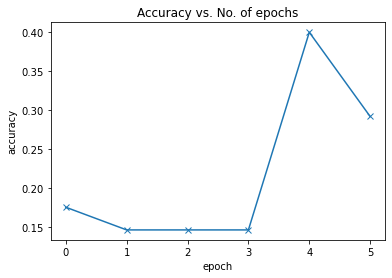

In [122]:
plot_accuracies(history)

In [40]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

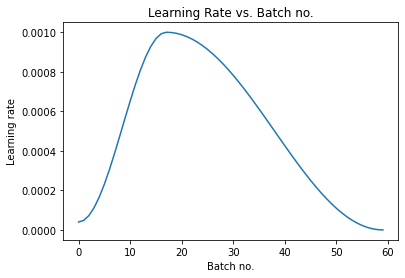

In [123]:
plot_lrs(history)

## Saving the Model



In [124]:
torch.save(model.state_dict(), './models/2_epoch_model.pth')

# Loading the Model

In [18]:
# model = to_device(ResNet(1, len(classes_train)), device)
load_model = to_device(ResNet(1, len(classes_train)), device)
checkpoint = torch.load('./states/30_epoch_state.pth')    # can't use this cause no GPU
# checkpoint = torch.load('./states/30_epoch_state.pth', map_location ='cpu')
load_model.load_state_dict(checkpoint['state_dict'])
load_epoch = checkpoint['epoch']
load_history = checkpoint['history']

In [19]:
load_model.train()

ResNet(
  (input): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )

## Loading new images to train with

In [26]:
data_dir = './data/junyi'

In [27]:
# Looking into the directory
# data_dir = '../dataset'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/test")
print(f'Train Classes - {classes_train}')
print(f'Test Classes - {classes_valid}')

['test', 'train']
Train Classes - ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Test Classes - ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [28]:
# Custom Emotion Detection datasets
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.ToTensor()])

valid_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/test', valid_tfms)

In [29]:
batch_size = 20

In [30]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

torch.Size([1, 48, 48])


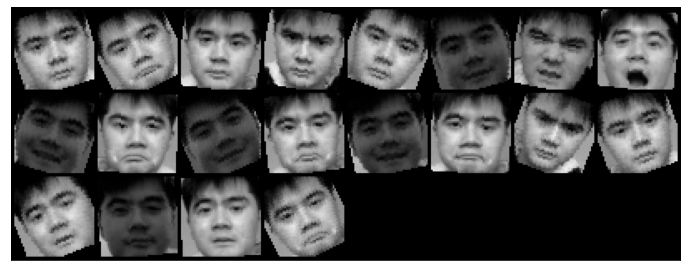

In [31]:
show_batch(train_dl)

In [32]:
# Loading data onto device
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [33]:
epochs = 10
max_lr = 0.001
grad_clip = 0.2
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [34]:
history = load_history

In [35]:
%%time
history += fit_one_cycle(epochs, max_lr, load_model, train_dl, valid_dl, 
                        grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00026, train_loss: 1.1820, val_loss: 0.6663, val_acc: 0.8170
Epoch [1], last_lr: 0.00075, train_loss: 0.7091, val_loss: 0.5407, val_acc: 0.8875
Epoch [2], last_lr: 0.00100, train_loss: 0.4977, val_loss: 0.4133, val_acc: 0.9500
Epoch [3], last_lr: 0.00095, train_loss: 0.2449, val_loss: 0.2720, val_acc: 0.8545
Epoch [4], last_lr: 0.00081, train_loss: 0.2333, val_loss: 0.1182, val_acc: 1.0000
Epoch [5], last_lr: 0.00061, train_loss: 0.1030, val_loss: 0.0868, val_acc: 1.0000
Epoch [6], last_lr: 0.00039, train_loss: 0.0756, val_loss: 0.0851, val_acc: 1.0000
Epoch [7], last_lr: 0.00019, train_loss: 0.0737, val_loss: 0.0626, val_acc: 1.0000
Epoch [8], last_lr: 0.00005, train_loss: 0.0690, val_loss: 0.0591, val_acc: 1.0000
Epoch [9], last_lr: 0.00000, train_loss: 0.0451, val_loss: 0.0554, val_acc: 1.0000
CPU times: total: 7.31 s
Wall time: 1min 39s


In [37]:
torch.save(load_model.state_dict(), './models/30_and_junyi_epoch_model.pth')

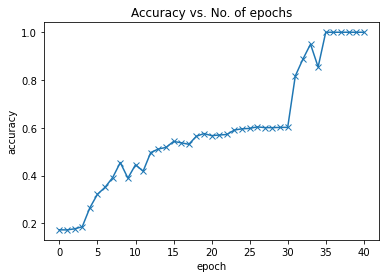

In [41]:
plot_accuracies(history)

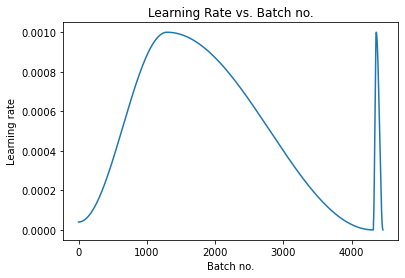

In [42]:
plot_lrs(history)

In [47]:
# Access emotion detector
!python video_capture.py

[ WARN:1@78.790] global D:\a\opencv-python\opencv-python\opencv\modules\videoio\src\cap_msmf.cpp (539) `anonymous-namespace'::SourceReaderCB::~SourceReaderCB terminating async callback
